# Clustering within food groups

This notebook provides a clustering analysis of the recipes within the food group and the different pairs, in detail:
<ol>
<li>all food groups</li> 
<li>meat</li> 
<li>vegan</li>
<li>pescatarian</li>
<li>meat, vegan</li>
<li>meat, pescatarian</li>
<li>pescatarian vegan</li>
</ol>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from loguru import logger
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist
from game import clustering_utils

[nltk_data] Downloading package stopwords to C:\Users\g.decillis.SS-
[nltk_data]     GDC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#preparing data
data_recipes = pd.read_csv('../data/recipe_table.csv', sep=';')
data_recipes = data_recipes.drop('Unnamed: 0', axis = 1)


#getting the embedding of 'key_ingredient', 'title' and 'description' from recipe2vec function. 
emb = pd.read_csv('../data/embedding.csv')

data = data_recipes.merge(emb)

data = clustering_utils.fill_missing_values(df=data, column= "food_group", name='other')
data = clustering_utils.fill_missing_values(df=data, column= "cuisine", name='other')
data = clustering_utils.fill_missing_values(df=data, column="season", name='other')

#data is replicated to preserve categorical features so that word cloud can be displayed later
#so data recipes keeps the information as word, not numbers 
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column= "food_group", name='other')
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column= "cuisine", name='other')
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column= "season", name='other')

#collapsing differentfour groups in only four groups, recipes under other are 4 only,. 
fg_dict = {'Beef':'meat', 'Chicken':'meat', 
           'Pork':'meat', 'Fish':'fish', 'Shellfish':'fish','Lamb':'meat', 'Vegan':'vegan',
           'other':'other'}

data['food_group'] = data['food_group'].map(fg_dict)
data_recipes['food_group'] = data_recipes['food_group'].map(fg_dict)

#The following columns are droppped because we will use the embedding produced by the rec2vec function.
#Specials has got too many missing values so it will be dropped too. Instructions will follow the same fate.
data = data.drop(["specials", "image_url",  
                  "instructions", "key_ingredient",
                  "title","description"], axis = 1)
data_recipes = data_recipes.drop(["specials"], axis = 1)

# text is cleaned
data_recipes = clustering_utils.preprocess_text_columns(data_recipes, ['allergens','cuisine', 'instructions', 
                                                      'key_ingredient', 'title','description'])

#categorical variables encoding
data = clustering_utils.count_allergens(df=data, column="allergens")
data = clustering_utils.label_encoding(df=data, column="cuisine")
data = clustering_utils.hot_encoding(df=data, columns=["season"])
data = data.set_index("id")

# The following lines address the problem of performing feature scaling before obtaining different data frames 
data['food_group_encoded'] = clustering_utils.count_encoding(df=data, column="food_group")['food_group']
data_scaled = clustering_utils.feat_scaler(MinMaxScaler(), data.drop('food_group', axis = 1))
data_scaled = pd.DataFrame(data_scaled, index = data.index, columns = data.drop('food_group', axis = 1).columns)

#data_all contains all the feature, Feature scaling has been made and now sub sets can be created
data_all = data_scaled
data_scaled['food_group'] = data_recipes.set_index('id')['food_group']
data = data_scaled.drop('food_group_encoded',axis = 1)

#create a dictionary where keys are food groups and values are dataframes
food_group_list = data_recipes['food_group'].unique()
data_recipes_dict = {group:data_recipes[data_recipes['food_group']==group]
                     .drop('food_group', axis = 1) 
                     for group in food_group_list }

data_dict = {group:data[data['food_group']==group]
             .drop('food_group', axis = 1) 
             for group in food_group_list}

#creating a dataframe for every possible choice of customer, if a customer decides all options, we use data all
data_mv = pd.concat([data_dict['meat'], data_dict['vegan']])
data_mf = pd.concat([data_dict['meat'], data_dict['fish']])
data_fv = pd.concat([data_dict['fish'], data_dict['vegan']])
data_m = data_dict['meat']
data_v = data_dict['vegan']
data_f = data_dict['fish']

2020-09-20 10:13:51.340 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column food_group with other
2020-09-20 10:13:51.340 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column cuisine with other
2020-09-20 10:13:51.348 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column season with other
2020-09-20 10:13:51.348 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column food_group with other
2020-09-20 10:13:51.356 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column cuisine with other
2020-09-20 10:13:51.356 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column season with other
2020-09-20 10:13:51.380 | INFO     | game.clustering_utils:preprocess_text_columns:118 - Preprocessing text columns
2020-09-20 10:13:51.380 | INFO     | game.clustering_utils:preprocess_text_columns

In [3]:
data_all = data_all.drop('food_group', axis = 1)

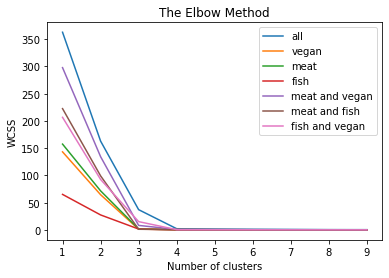

In [9]:
#pca
n_components = 2
X_all = clustering_utils.pca_(data_all, n_components = n_components)
X_v = clustering_utils.pca_(data_v, n_components = n_components ) 
X_m = clustering_utils.pca_(data_m, n_components = n_components)
X_f = clustering_utils.pca_(data_f, n_components = n_components)
X_mv = clustering_utils.pca_(data_mv, n_components = n_components)
X_mf = clustering_utils.pca_(data_mf, n_components = n_components)
X_fv = clustering_utils.pca_(data_fv, n_components = n_components)

clustering_utils.WCSS_plotter(X_all, X_v, X_m, X_f, X_mv, X_mf, X_fv)

### Preliminary analysis of clusters for ALL the recipes, regardless the food group.
If another dataframe has to be analysed, please change "X = X_all" according to the choice.

Text(0.5, 1.0, '2 Principal Components')

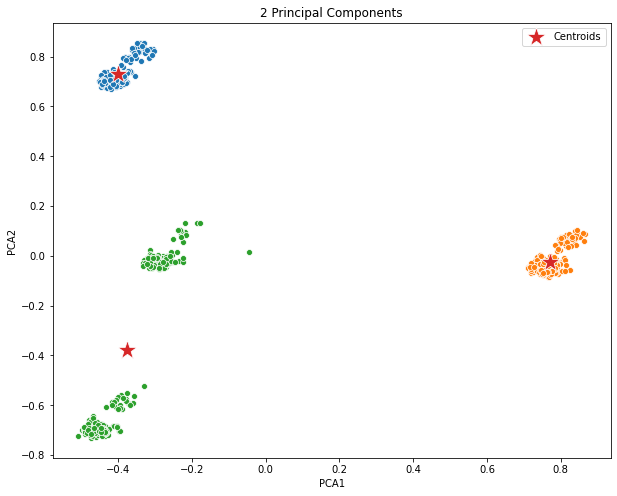

In [5]:
#According to the Elbow graph we deterrmine the clusters number as 3. 
kmeans = KMeans(n_clusters=3, init ='k-means++', random_state=42)

X = X_all
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x = X[y_kmeans == 0, 0], y = X[y_kmeans == 0, 1] , palette='Paired')
sns.scatterplot(x = X[y_kmeans == 1, 0], y = X[y_kmeans == 1, 1] , palette='Paired')
sns.scatterplot(x = X[y_kmeans == 2, 0], y = X[y_kmeans == 2, 1] , palette='Paired')
#sns.scatterplot(x = X[y_kmeans == 3, 0], y = X[y_kmeans == 3, 1] , palette='Paired')

#Plot the centroid with cluster_centres attribute.
sns.scatterplot(x = kmeans.cluster_centers_[:, 0], 
                y = kmeans.cluster_centers_[:, 1], 
                s = 400, label = 'Centroids', marker='*'
               )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('2 Principal Components')

In [6]:
#Uncomment if the n_components of pca is different than 2
#X = pd.DataFrame(X, columns = data.columns, index = data.index)
X = pd.DataFrame(X, columns = ['pca1','pca2'], index = data.index)

X["cluster"] = y_kmeans

data_clust = data.copy()
data_clust['cluster'] = X['cluster']

data_recipes = data_recipes.set_index('id')
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column= "food_group", name='other')
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column= "cuisine", name='other')
data_recipes = clustering_utils.fill_missing_values(df=data_recipes, column="season", name='other')
data_recipes = clustering_utils.preprocess_text_columns(data_recipes, data_recipes.select_dtypes(include = 'object').columns)

data_recipes['cluster'] = data_clust['cluster']

2020-09-20 10:14:08.120 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column food_group with other
2020-09-20 10:14:08.120 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column cuisine with other
2020-09-20 10:14:08.128 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column season with other
2020-09-20 10:14:08.136 | INFO     | game.clustering_utils:preprocess_text_columns:118 - Preprocessing text columns
2020-09-20 10:14:08.136 | INFO     | game.clustering_utils:preprocess_text_columns:122 - Stripping punctuation and symbol for allergens
2020-09-20 10:14:08.144 | INFO     | game.clustering_utils:preprocess_text_columns:125 - Stripping digits and stopwords for allergens
2020-09-20 10:14:08.152 | INFO     | game.clustering_utils:preprocess_text_columns:122 - Stripping punctuation and symbol for cuisine
2020-09-20 10:14:08.160 | INFO     | game.clustering_utils:preprocess_text_colu

2020-09-20 10:14:13.776 | INFO     | __main__:<module>:5 - The followings are the wordclounds for title


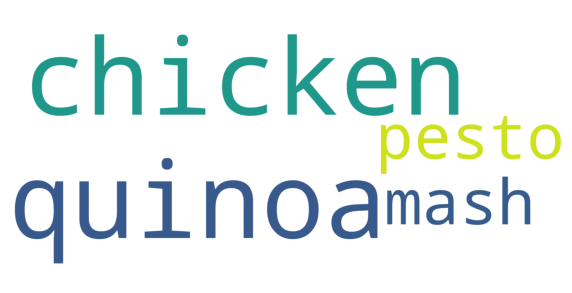

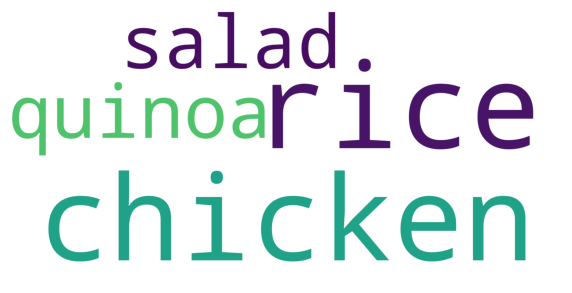

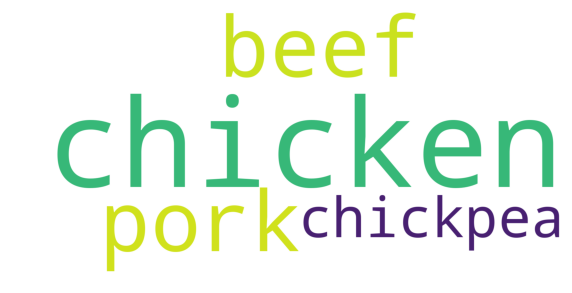

2020-09-20 10:14:20.720 | INFO     | __main__:<module>:5 - The followings are the wordclounds for key_ingredient


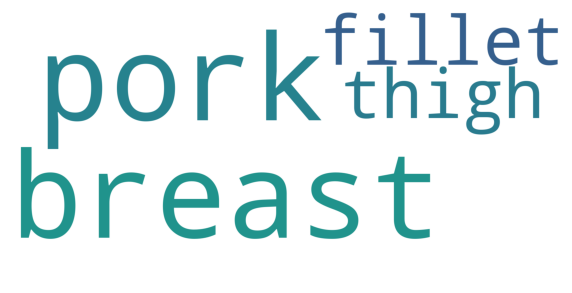

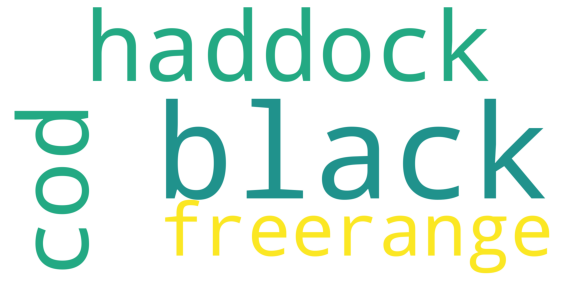

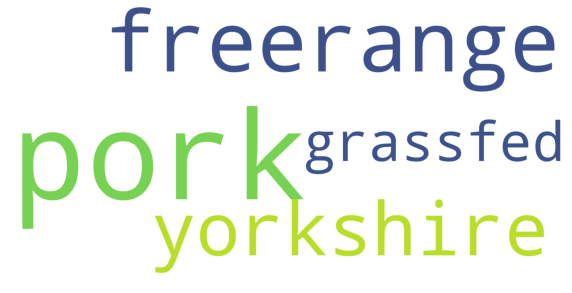

2020-09-20 10:14:27.543 | INFO     | __main__:<module>:5 - The followings are the wordclounds for description


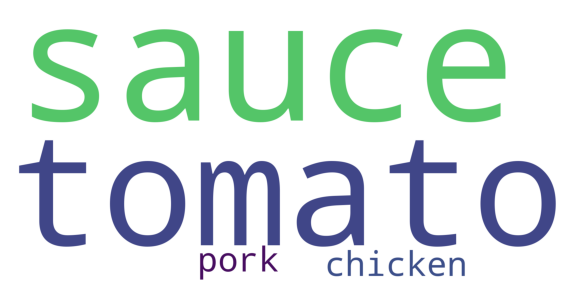

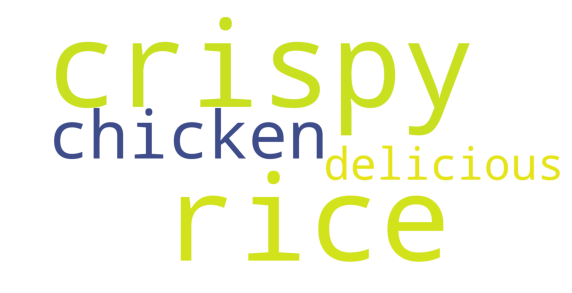

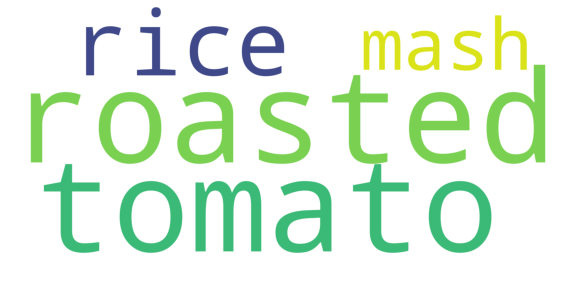

2020-09-20 10:14:35.204 | INFO     | __main__:<module>:5 - The followings are the wordclounds for instructions


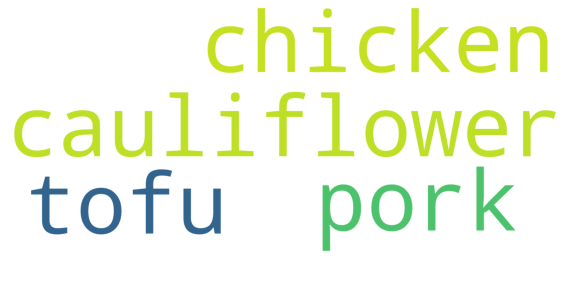

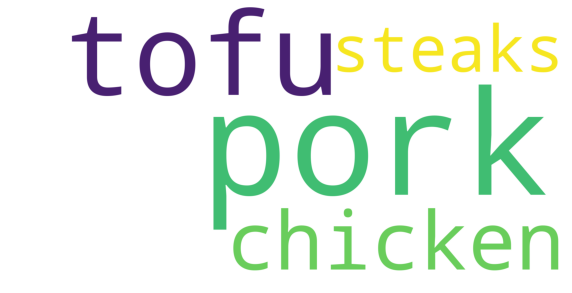

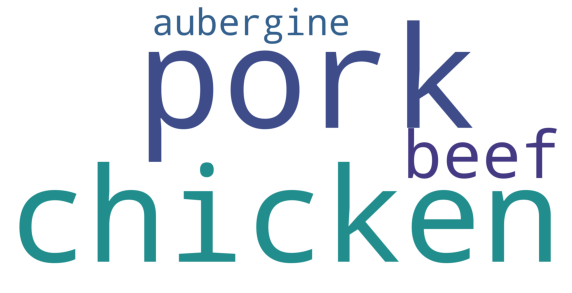

In [7]:
#Each function outputs four word clouds
descriptors = ['title', 'key_ingredient','description','instructions']

for descriptor in descriptors:
    logger.info(f"The followings are the wordclounds for {descriptor}")
    clustering_utils.show_words_cloud(data_recipes, descriptor, 10, 4)